In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.reset_orig()


from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
from statsmodels.tools.sm_exceptions import  ValueWarning 
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)

from utils.constants import *

In [2]:
start_index = HOURS_PER_YEAR + HOURS_PER_MONTH
training_length = HOURS_PER_WEEK
testing_length = HOURS_PER_DAY

In [3]:
data = pd.read_csv('2022_2023/2023_data_with_imbalance.csv', index_col=0)
data.index = pd.date_range(start='1/1/2022', periods=len(data), freq='h')
# Add columns for time of day, day of week, and month
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data.drop(columns=['forward_FC','production_RE','Offshore DK1','Onshore DK1'], inplace=True)
data.head()

,forward_RE,prices_SB,production_FC,Offshore DK2,Onshore DK2,day_ahead_gen,day_ahead_solar_gen,day_ahead_wind_offshore_gen,day_ahead_wind_onshore_gen,day_ahead_load,hour,day_of_week,month
2022-01-01 00:00:00,41.33,41.33,1.000000,0.274701,0.680247,1736.0,0.0,311.0,245,1340,0,5,1
2022-01-01 01:00:00,42.18,42.18,1.000000,0.356135,0.796296,1745.0,0.0,316.0,263,1280,1,5,1
2022-01-01 02:00:00,44.37,44.37,0.776486,0.279045,0.728395,1710.0,0.0,294.0,253,1238,2,5,1
2022-01-01 03:00:00,37.67,37.67,0.935938,0.228013,0.698765,1603.0,0.0,294.0,235,1212,3,5,1
2022-01-01 04:00:00,39.70,39.70,1.000000,0.221498,0.690123,1451.0,0.0,280.0,215,1205,4,5,1


## Benchmark

In [4]:
# Calculate the mean RMSE when predicting the next hour's price to be the same as the current hour's price
from sklearn.metrics import mean_squared_error
from math import sqrt

y_true_naive = data['prices_SB'][start_index:]
y_pred_naive = data['prices_SB'][start_index-1:-1]
rmse = sqrt(mean_squared_error(y_true_naive, y_pred_naive))
print('RMSE:', rmse)

RMSE: 68.87380994794776


<Axes: >

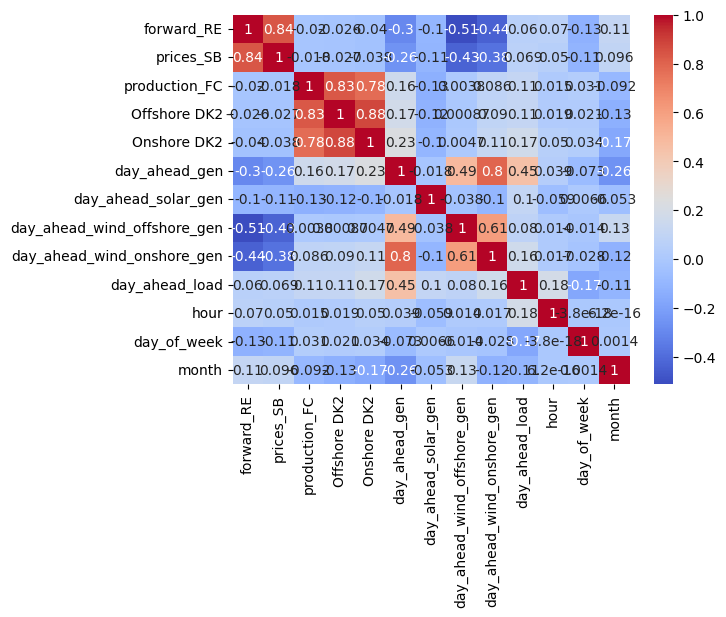

In [5]:
#Correlation heatmap
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

In [6]:
data.drop(columns=['day_ahead_load','production_FC','Offshore DK2','Onshore DK2'], inplace=True)

for i in range(1,24):
    data[f'prices_SB_{i}'] = data['prices_SB'].shift(i)
    data[f'forward_RE_{i}'] = data['forward_RE'].shift(i)

data.dropna(inplace=True)

In [75]:
data['prices_diff'] = data['forward_RE'] - data['prices_SB']

In [16]:
datalag = pd.DataFrame()
# Add 24 columns for the previous 24 prices_diff
for i in range(1, 25):
    datalag[f'prices_diff_{i}'] = data['prices_diff'].shift(i)
    # data[f'prices_SB{i}'] = data['prices_SB'].shift(i)
    
data.dropna(inplace=True)

0.7317510874542125


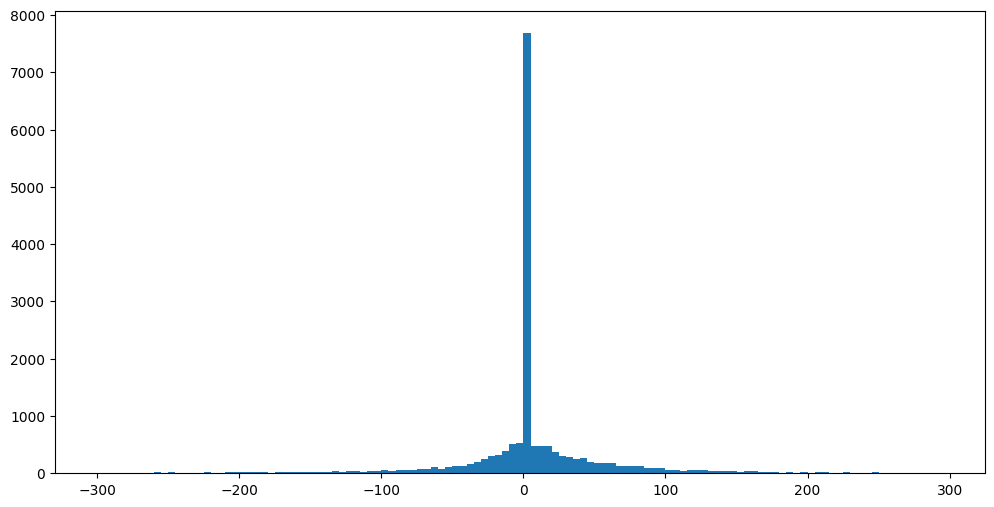

In [11]:
#Plot a histogram of prices diff for every hour (%24 hours)
bins_edges = np.arange(-300, 300, 5)
print(np.mean(data['prices_diff']))
plt.figure(figsize=(12,6))
plt.hist(data['prices_diff'], bins=bins_edges)
plt.show()

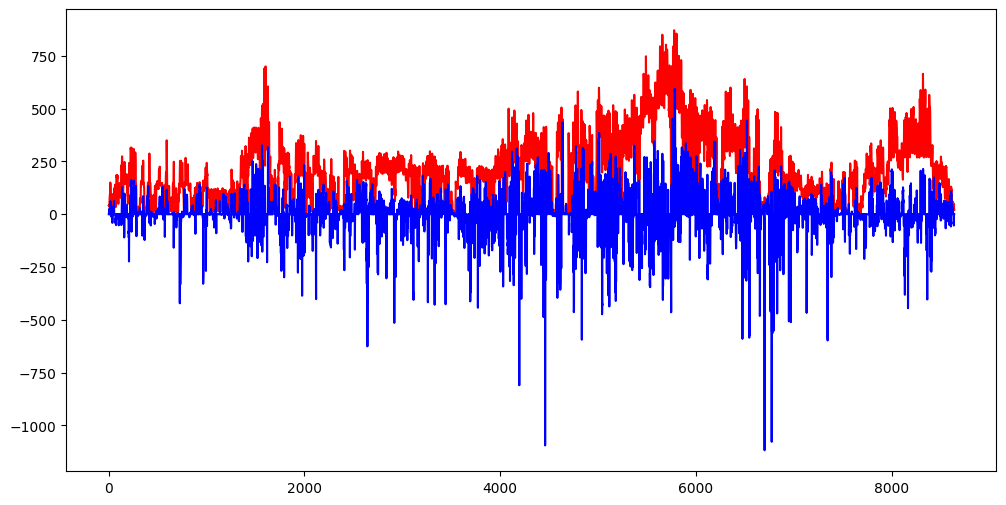

In [47]:
plt.figure(figsize=(12,6))
plt.plot(data['forward_RE'][:HOURS_PER_YEAR],color='red', label='prices_SB')
plt.plot(data['prices_diff'][:HOURS_PER_YEAR],color='blue', label='prices_diff')
plt.show()

## Regression

In [17]:
from xgboost import XGBRegressor
#Random Forest
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

start_index = HOURS_PER_YEAR + HOURS_PER_MONTH
training_length = HOURS_PER_MONTH
testing_length = HOURS_PER_DAY

X = data.drop(columns=['prices_SB'])
y = data['prices_SB']
X_train = X.iloc[:start_index]
y_train = y.iloc[:start_index]

X_test = X.iloc[start_index:]
y_test = y.iloc[start_index:]

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [18]:
display(data)

,forward_RE,prices_SB,day_ahead_gen,day_ahead_solar_gen,day_ahead_wind_offshore_gen,day_ahead_wind_onshore_gen,hour,day_of_week,month,prices_SB_1,...,prices_SB_19,forward_RE_19,prices_SB_20,forward_RE_20,prices_SB_21,forward_RE_21,prices_SB_22,forward_RE_22,prices_SB_23,forward_RE_23
2022-01-01 23:00:00,34.73,27.00,1724.0,0.0,320.0,381,23,5,1,28.00,...,39.70,39.70,37.67,37.67,44.37,44.37,42.18,42.18,41.33,41.33
2022-01-02 00:00:00,34.39,45.00,1718.0,0.0,313.0,375,0,6,1,27.00,...,40.59,40.59,39.70,39.70,37.67,37.67,44.37,44.37,42.18,42.18
2022-01-02 01:00:00,34.36,45.00,1781.0,0.0,290.0,355,1,6,1,45.00,...,43.26,43.26,40.59,40.59,39.70,39.70,37.67,37.67,44.37,44.37
2022-01-02 02:00:00,34.10,34.10,1719.0,0.0,254.0,311,2,6,1,45.00,...,43.14,49.66,43.26,43.26,40.59,40.59,39.70,39.70,37.67,37.67
2022-01-02 03:00:00,29.56,29.56,1749.0,0.0,246.0,283,3,6,1,34.10,...,43.13,70.05,43.14,49.66,43.26,43.26,40.59,40.59,39.70,39.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 19:00:00,30.02,60.00,1937.0,0.0,836.0,444,19,4,12,57.91,...,-0.50,15.66,-6.30,15.06,-14.09,15.29,5.00,26.24,17.50,33.62
2023-12-29 20:00:00,28.13,65.00,1887.0,0.0,848.0,455,20,4,12,60.00,...,-0.50,15.48,-0.50,15.66,-6.30,15.06,-14.09,15.29,5.00,26.24
2023-12-29 21:00:00,25.34,65.00,1860.0,0.0,854.0,447,21,4,12,65.00,...,-2.00,15.43,-0.50,15.48,-0.50,15.66,-6.30,15.06,-14.09,15.29
2023-12-29 22:00:00,19.35,55.66,1820.0,0.0,851.0,421,22,4,12,65.00,...,-2.00,15.04,-2.00,15.43,-0.50,15.48,-0.50,15.66,-6.30,15.06


In [19]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 28.768200158799694
RMSE: 65.62356571874808


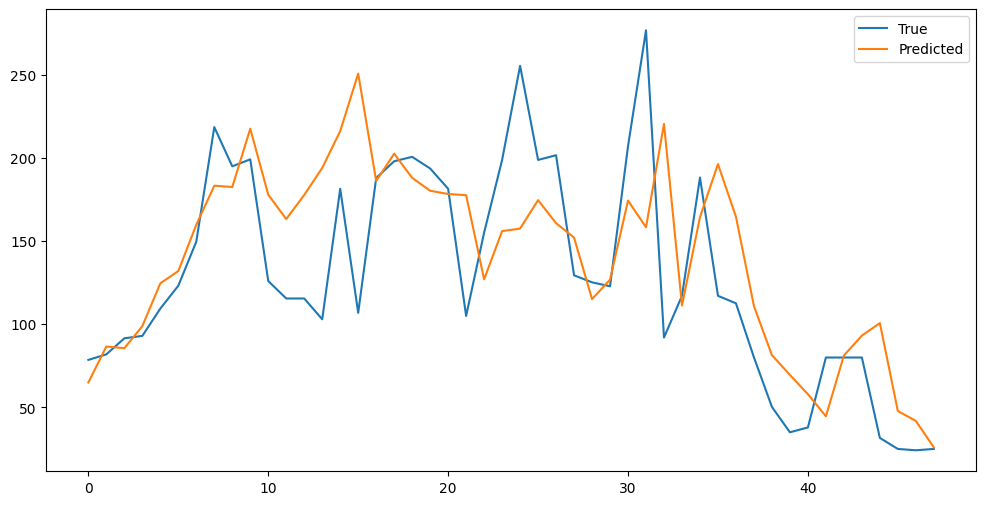

In [16]:
plot_length = 2*HOURS_PER_DAY
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:plot_length], label='True')
plt.plot(y_pred[:plot_length], label='Predicted')
plt.legend()
plt.show()

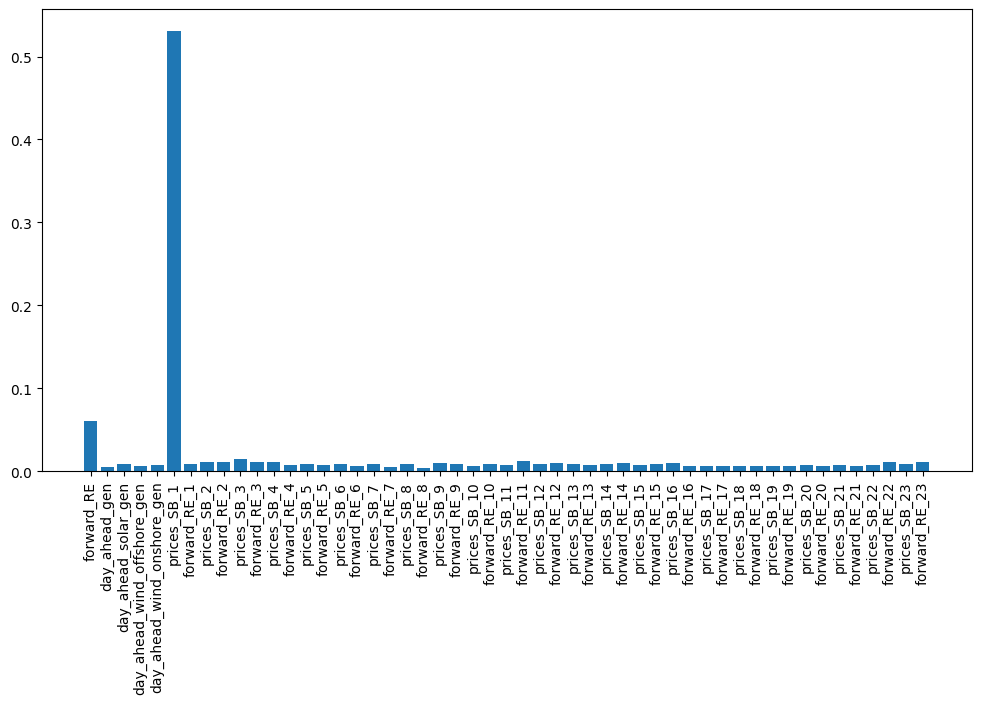

In [68]:
# Feature importance
plt.figure(figsize=(12,6))
plt.bar(X.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

## Classification

In [55]:
classification_data = data.copy()

In [56]:
classification_data['balancing_state'] = np.where(classification_data['forward_RE'] > classification_data['prices_SB'], 0, np.where(classification_data['forward_RE'] == classification_data['prices_SB'], 1, 2))

In [60]:
#XGBoost
from xgboost import XGBClassifier
# import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

X = classification_data.drop(columns=['prices_SB','balancing_state'])
y = classification_data['balancing_state']
X_train = X.iloc[start_index-training_length:start_index]
y_train = y.iloc[start_index-training_length:start_index]


X_test = X.iloc[start_index:start_index+testing_length]
y_test = y.iloc[start_index:start_index+testing_length]

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [61]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.5


In [62]:
print('MAE:', np.mean(np.abs(y_test - y_pred)))
print('RMSE:', np.sqrt(np.mean((y_test - y_pred)**2)))

MAE: 0.5
RMSE: 0.7071067811865476


In [63]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)


array([[4, 3, 0],
       [7, 8, 1],
       [0, 1, 0]], dtype=int64)

# ARIMAX

In [7]:
# Perform statistical tests to check the stationarity of the time series
from statsmodels.tsa.stattools import adfuller

def adf_test(series, signif=0.05):
    dftest = adfuller(series, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [8]:
adf_test(data['prices_SB'])

Test Statistic         -8.000888e+00
p-value                 2.335689e-12
# Lags                  4.400000e+01
# Observations          1.742300e+04
Critical Value (1%)    -3.430725e+00
Critical Value (5%)    -2.861706e+00
Critical Value (10%)   -2.566858e+00
dtype: float64
 Series is Stationary


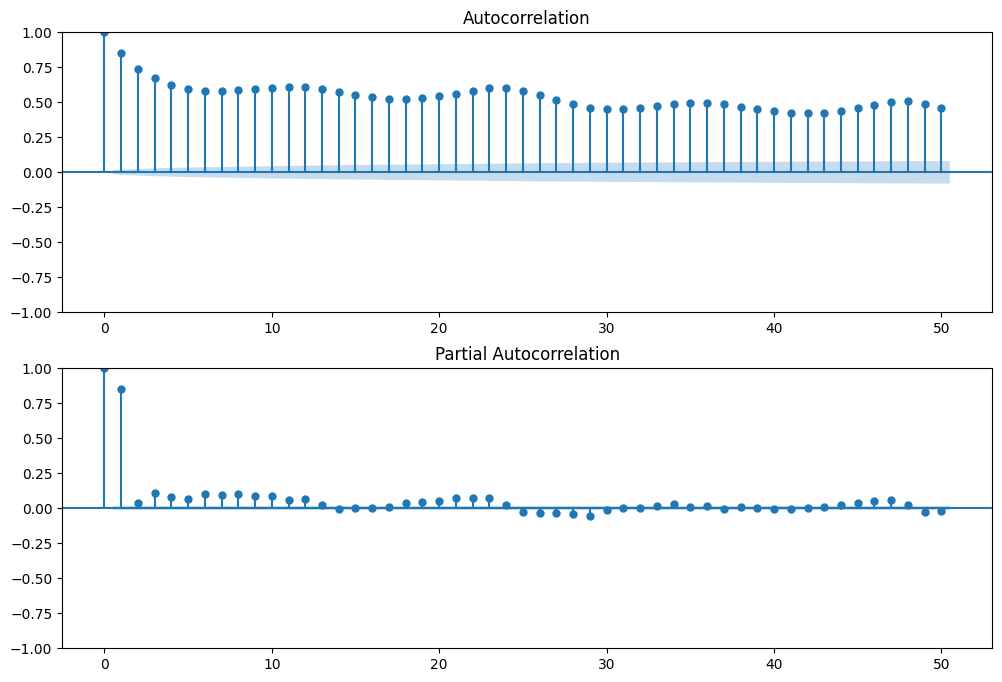

In [9]:
# acf and pacf plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['prices_SB'], lags=50, ax=ax[0])
plot_pacf(data['prices_SB'], lags=50, ax=ax[1])
plt.show()

In [10]:
arima_data = data.drop([f'prices_SB_{i}' for i in range(1,5)], axis=1)
arima_data.drop(['prices_SB'], axis=1, inplace=True)
arima_labels = data['prices_SB']
display(arima_data.head())
display(arima_labels.head())

,forward_RE,day_ahead_gen,day_ahead_solar_gen,day_ahead_wind_offshore_gen,day_ahead_wind_onshore_gen,forward_RE_1,forward_RE_2,forward_RE_3,forward_RE_4
4,39.70,1451.0,0.0,280.0,215,37.67,44.37,42.18,41.33
5,40.59,1533.0,0.0,289.0,209,39.70,37.67,44.37,42.18
6,43.26,1557.0,0.0,302.0,192,40.59,39.70,37.67,44.37
7,49.66,1638.0,0.0,287.0,169,43.26,40.59,39.70,37.67
8,70.05,1485.0,2.0,261.0,134,49.66,43.26,40.59,39.70


4    39.70
5    40.59
6    43.26
7    43.14
8    43.13
Name: prices_SB, dtype: float64

In [27]:
from pmdarima import auto_arima

model = auto_arima(arima_labels[:start_index], seasonal=False)
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9360
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -54679.174
Date:                Mon, 22 Jul 2024   AIC                         109368.348
Time:                        13:12:32   BIC                         109404.068
Sample:                             0   HQIC                        109380.479
                               - 9360                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3921      0.040     34.634      0.000       1.313       1.471
ar.L2         -0.5386      0.026    -20.661      0.000      -0.590      -0.488
ma.L1         -1.6176      0.042    -38.319      0.000      -1.700      -1.535
ma.L2          0.6492      0.040     16.367      0.000       0.571       0.727
sigma2      6952.4368     35.446    196.140      0.000    6882.963    7021.910
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):            109087.37
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
model_fit = model.fit(arima_labels[:start_index])

In [29]:
rmse_list = []
first_hour_rmse_list = []
for i in range(start_index, len(data) - HOURS_PER_DAY):
    y_pred = model_fit.predict(testing_length)
    rmse = np.sqrt(mean_squared_error(data['prices_SB'][i:i+testing_length], y_pred))
    rmse_list.append(rmse)
    first_hour_rmse = np.sqrt(mean_squared_error(data['prices_SB'][i:i+1], y_pred[:1]))
    first_hour_rmse_list.append(first_hour_rmse)

print(f'Mean RMSE: {np.mean(rmse_list)}')
print(f'Mean first hour RMSE: {np.mean(first_hour_rmse_list)}')

C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mathi\Desktop\DTU Internship\feature-driven-trading-of-wind-power-and-hydrogen\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction

Mean RMSE: 143.89319600922212
Mean first hour RMSE: 84.93735716474069


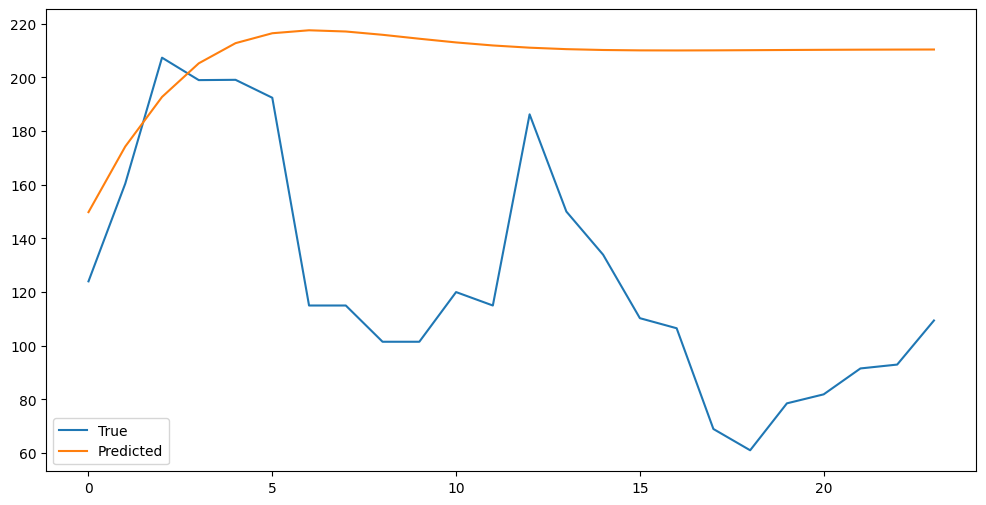

In [31]:
plt.figure(figsize=(12,6))
plt.plot(data['prices_SB'][start_index:start_index+testing_length].to_numpy(), label='True')
plt.plot(y_pred.values, label='Predicted')
plt.legend()
plt.show()